# Examining Performance vs Variables

In [1]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [2]:
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Add the path to the parent directory to augment search for module
if "../../.." not in sys.path:
    print("adding pardir")
    sys.path.append("../../..")

from WatChMaL_analysis.short_tank_EDA.old_reflector_short_tank_exploratory_data_analysis.exploratory_data_analysis_utils import *

from WatChMaL_analysis.WatChMaL.analysis.multi_plot_utils import multi_disp_learn_hist, multi_compute_roc, multi_plot_roc
from WatChMaL_analysis.WatChMaL.analysis.plot_utils import compute_roc
from WatChMaL_analysis.WatChMaL.analysis.comparison_utils import multi_get_masked_data, multi_collapse_test_output

adding pardir


## Load Data From H5

In [4]:
# Import test events from h5 file
data_path = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_emg_E0to1000MeV_digihits.h5"
data_file = h5py.File(data_path, "r")

print(data_file.keys())

hdf5_hit_pmt    = data_file["hit_pmt"]
hdf5_hit_time   = data_file["hit_time"]
hdf5_hit_charge = data_file["hit_charge"]


hit_pmt    = np.memmap(data_path, mode="r", shape=hdf5_hit_pmt.shape,
                                    offset=hdf5_hit_pmt.id.get_offset(), dtype=hdf5_hit_pmt.dtype)

hit_time   = np.memmap(data_path, mode="r", shape=hdf5_hit_time.shape,
                                    offset=hdf5_hit_time.id.get_offset(), dtype=hdf5_hit_time.dtype)

hit_charge = np.memmap(data_path, mode="r", shape=hdf5_hit_charge.shape,
                                    offset=hdf5_hit_charge.id.get_offset(), dtype=hdf5_hit_charge.dtype)

angles     = np.array(data_file['angles'])
energies   = np.array(data_file['energies'])
positions  = np.array(data_file['positions'])
labels     = np.array(data_file['labels'])
root_files = np.array(data_file['root_files'])

<KeysViewHDF5 ['angles', 'energies', 'event_hits_index', 'event_ids', 'hit_charge', 'hit_pmt', 'hit_time', 'labels', 'positions', 'root_files', 'veto', 'veto2']>


## Load Indices

In [5]:
idxs_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_3M_OD_veto_idxs.npz'
idxs = np.load(idxs_path, allow_pickle=True)

train_idxs = idxs['train_idxs']
val_idxs   = idxs['val_idxs']
test_idxs  = idxs['test_idxs']

## Split Datasets

In [6]:
train_angles    = angles[train_idxs]
train_energies  = energies[train_idxs]
train_positions = positions[train_idxs]
train_labels    = labels[train_idxs]

train_info = {'name':'Training Set','energies':train_energies,'positions':train_positions, 'angles':train_angles, 'labels':train_labels}

print("Done train info")

val_angles     = angles[val_idxs]
val_energies   = energies[val_idxs]
val_positions  = positions[val_idxs]
val_labels     = labels[val_idxs]

val_info = {'name':'Validation Set','energies':val_energies,'positions':val_positions, 'angles':val_angles, 'labels':val_labels}

print("Done val info")

test_angles    = angles[test_idxs]
test_energies  = energies[test_idxs]
test_positions = positions[test_idxs]
test_labels    = labels[test_idxs]
test_info = {'name':'Test Set','energies':test_energies,'positions':test_positions, 'angles':test_angles, 'labels':test_labels}

print("Done test info")

Done train info
Done val info
Done test info


In [7]:
dataset_info = [train_info, val_info, test_info]

In [8]:
train_g_idxs = np.where(dataset_info[0]['labels']==0)[0]
val_g_idxs   = np.where(dataset_info[1]['labels']==0)[0]
test_g_idxs  = np.where(dataset_info[2]['labels']==0)[0]

g_idxs = np.concatenate((train_g_idxs, val_g_idxs, test_g_idxs))

train_e_idxs = np.where(dataset_info[0]['labels']==1)[0]
val_e_idxs   = np.where(dataset_info[1]['labels']==1)[0]
test_e_idxs  = np.where(dataset_info[2]['labels']==1)[0]

e_idxs = np.concatenate((train_e_idxs, val_e_idxs, test_e_idxs))

train_m_idxs = np.where(dataset_info[0]['labels']==2)[0]
val_m_idxs   = np.where(dataset_info[1]['labels']==2)[0]
test_m_idxs  = np.where(dataset_info[2]['labels']==2)[0]

m_idxs = np.concatenate((train_m_idxs, val_m_idxs, test_m_idxs))

In [9]:
# Load normal energies
train_g_energies = dataset_info[0]['energies'][train_g_idxs]
val_g_energies   = dataset_info[1]['energies'][val_g_idxs]
test_g_energies  = dataset_info[2]['energies'][test_g_idxs]

g_energies = np.concatenate((train_g_energies, val_g_energies, test_g_energies))

train_e_energies = dataset_info[0]['energies'][train_e_idxs]
val_e_energies   = dataset_info[1]['energies'][val_e_idxs]
test_e_energies  = dataset_info[2]['energies'][test_e_idxs]

e_energies = np.concatenate((train_e_energies, val_e_energies, test_e_energies))

train_m_energies = dataset_info[0]['energies'][train_m_idxs]
val_m_energies   = dataset_info[1]['energies'][val_m_idxs]
test_m_energies  = dataset_info[2]['energies'][test_m_idxs]

m_energies = np.concatenate((train_m_energies, val_m_energies, test_m_energies))

# Load Evaluation Data

In [10]:
label_dict         = {"$\gamma$":0, "$e$":1, "$\mu$":2}
inverse_label_dict = {0:"$\gamma$", 1:"$e$", 2:"$\mu$"}

muon_softmax_index_dict = {"e/gamma":0, "mu":1}

c = plt.cm.viridis(np.linspace(0,1,10)) #plt.rcParams['axes.prop_cycle'].by_key()['color']

In [24]:
############# define run locations #############
locs = ['/home/jtindall/WatChMaL/outputs/2021-02-16/full_veto_train_full_veto_test/outputs'
        #'/home/jtindall/WatChMaL/outputs/2021-02-08/no_veto_train_full_veto_test/outputs' # trained with no veto
        ]

titles = ['Short Tank No Veto Run 1',
          'Short Tank No Veto Run 2']

In [25]:
############# load short tank run data #############
raw_output_softmax = [np.load(loc + "/softmax.npy") for loc in locs]
raw_actual_labels  = [np.load(loc + "/labels.npy") for loc in locs]
raw_actual_indices = [np.load(loc + "/indices.npy") for loc in locs]
#raw_actual_root_files  = [np.load(loc + "/root_files.npy") for loc in locs]

sample_softmax = raw_output_softmax[0]
sample_labels  = raw_actual_labels[0]
sample_indices = raw_actual_indices[0]
#sample_root_files = raw_actual_root_files[0]

sample_softmax = sample_softmax[np.argsort(sample_indices)]
sample_labels  = sample_labels[np.argsort(sample_indices)]

# Compare loaded data

In [26]:
print(test_idxs.shape)
print(sample_indices.shape)

(2756358,)
(2756358,)


In [27]:
print(test_idxs[0:5])
print(sample_indices[0:5])

[10463637 10463638 10463639 10463640 10463641]
[387760 387761 387762 387763 387764]


In [28]:
print(sample_labels.shape)
print(test_labels.shape)

print(np.bincount(sample_labels))
print(np.bincount(test_labels))

(2756358,)
(2756358,)
[1056157 1048237  651964]
[1056157 1048237  651964]


In [29]:
print(test_labels[0:5])
print(sample_labels[0:5])

[1 1 1 1 1]
[1 1 1 1 1]


In [30]:
print(np.all(test_labels[np.argsort(test_idxs)] == sample_labels[np.argsort(sample_indices)]))

False


In [31]:
comparison = test_labels[np.argsort(test_idxs)] == sample_labels[np.argsort(sample_indices)]
print(np.all(comparison))
print(np.where(~comparison))

False
(array([      0,       1,       2, ..., 2748401, 2748402, 2748403]),)


In [32]:
print(test_labels[np.argsort(test_idxs)][0:5])
print(sample_labels[np.argsort(sample_indices)][0:5])

[1 1 1 1 1]
[2 2 2 2 2]


In [33]:
test_g_subset   = test_labels[test_labels == 0]
sample_g_subset = sample_labels[sample_labels == 0]

test_2 = test_g_subset[np.argsort(test_idxs[test_labels == 0])] == sample_g_subset[np.argsort(sample_indices[test_labels == 0])]
print(np.all(test_2))

True


In [34]:
test_g_subset   = test_labels[test_labels == 1]
sample_g_subset = sample_labels[sample_labels == 1]

test_2 = test_g_subset[np.argsort(test_idxs[test_labels == 1])] == sample_g_subset[np.argsort(sample_indices[test_labels == 1])]
print(np.all(test_2))

True


In [35]:
test_g_subset   = test_labels[test_labels == 2]
sample_g_subset = sample_labels[sample_labels == 2]

test_2 = test_g_subset[np.argsort(test_idxs[test_labels == 2])] == sample_g_subset[np.argsort(sample_indices[sample_labels == 2])]
print(np.all(test_2))

True


In [36]:
np.argsort(sample_indices[sample_labels == 2])
np.argsort(sample_indices[sample_labels == 2])
np.argsort(sample_indices[sample_labels == 2])

array([481301, 481302, 481303, ..., 260558, 260559, 260560])

In [37]:
print(sample_labels)
print(test_labels)

[1 1 1 ... 0 0 0]
[1 1 1 ... 0 0 0]


In [38]:
print(dataset_info[2]['energies'][512+0:512 + 10])

[[262.82596 ]
 [971.25806 ]
 [ 35.589516]
 [778.4302  ]
 [873.6214  ]
 [ 89.03524 ]
 [766.17413 ]
 [969.7192  ]
 [749.7279  ]
 [745.6394  ]]


In [39]:
print(set(sample_labels - test_labels))

{0}


In [40]:
print(root_files[test_idxs][0:5])

[b'/localscratch/prouse.57033723.0/WCSim/e-/E0to1000MeV/unif-pos-R400-y300cm/4pi-dir/IWCD_mPMT_Short_e-_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir_3000evts_1561.root'
 b'/localscratch/prouse.57033723.0/WCSim/e-/E0to1000MeV/unif-pos-R400-y300cm/4pi-dir/IWCD_mPMT_Short_e-_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir_3000evts_1561.root'
 b'/localscratch/prouse.57033723.0/WCSim/e-/E0to1000MeV/unif-pos-R400-y300cm/4pi-dir/IWCD_mPMT_Short_e-_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir_3000evts_1561.root'
 b'/localscratch/prouse.57033723.0/WCSim/e-/E0to1000MeV/unif-pos-R400-y300cm/4pi-dir/IWCD_mPMT_Short_e-_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir_3000evts_1561.root'
 b'/localscratch/prouse.57033723.0/WCSim/e-/E0to1000MeV/unif-pos-R400-y300cm/4pi-dir/IWCD_mPMT_Short_e-_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir_3000evts_1561.root']


In [41]:
print(sample_root_files[np.argsort(sample_indices)][0:5])

NameError: name 'sample_root_files' is not defined

In [ ]:
#assert(np.all(root_files[test_idxs][0:5] == sample_root_files[np.argsort(sample_indices)][0:5]))

In [ ]:
#assert(np.all(root_files[test_idxs] == sample_root_files[np.argsort(sample_indices)]))

In [ ]:
#assert(np.all(test_labels == sample_labels[np.argsort(sample_indices)]))

In [42]:
sample_softmax = raw_output_softmax[0]
sample_labels  = raw_actual_labels[0]
sample_indices = raw_actual_indices[0]

In [43]:
"""
Want to:
-Look at events within a specific energy bin
-Look at rejection vs distance to wall at a constant efficiency
"""

'\nWant to:\n-Look at events within a specific energy bin\n-Look at rejection vs distance to wall at a constant efficiency\n'

# Event Breakdown By Energy for Muons

In [44]:
# Compute distance to wall for all events
"""
pbar = ProgressBar(widgets=['Calculating Distance to Wall. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=reduce(lambda x,y:x+y , list(map(lambda x : x['positions'].shape[0], dataset_info))))

pbar.start()
done=0
for dset in dataset_info:
    d_to_wall = []
    for i in range(dset['positions'].shape[0]):
        pbar.update(done + i)
        d_to_wall.append(distance_to_wall(dset['positions'][i][0], dset['angles'][i]))
        dset['d_to_wall'] = d_to_wall
    done = done + dset['positions'].shape[0]
pbar.finish()

np.savez('./performance_analysis_data/updated_OD_veto_dist_to_wall.npz', train_d_to_wall= dataset_info[0]['d_to_wall'],
                                                                 val_d_to_wall  = dataset_info[1]['d_to_wall'],
                                                                 test_d_to_wall = dataset_info[2]['d_to_wall'])
"""

"\npbar = ProgressBar(widgets=['Calculating Distance to Wall. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),\n           ' ', ETA()], maxval=reduce(lambda x,y:x+y , list(map(lambda x : x['positions'].shape[0], dataset_info))))\n\npbar.start()\ndone=0\nfor dset in dataset_info:\n    d_to_wall = []\n    for i in range(dset['positions'].shape[0]):\n        pbar.update(done + i)\n        d_to_wall.append(distance_to_wall(dset['positions'][i][0], dset['angles'][i]))\n        dset['d_to_wall'] = d_to_wall\n    done = done + dset['positions'].shape[0]\npbar.finish()\n\nnp.savez('./performance_analysis_data/updated_OD_veto_dist_to_wall.npz', train_d_to_wall= dataset_info[0]['d_to_wall'],\n                                                                 val_d_to_wall  = dataset_info[1]['d_to_wall'],\n                                                                 test_d_to_wall = dataset_info[2]['d_to_wall'])\n"

In [45]:
d_to_wall = np.load('./performance_analysis_data/updated_OD_veto_dist_to_wall.npz', allow_pickle=True)

dataset_info[0]['d_to_wall'] = d_to_wall['train_d_to_wall']
dataset_info[1]['d_to_wall'] = d_to_wall['val_d_to_wall']
dataset_info[2]['d_to_wall'] = d_to_wall['test_d_to_wall']

print(dataset_info[2]['labels'].shape)
print(dataset_info[2]['d_to_wall'].shape)

(2756358,)
(2756358,)


In [46]:
# Load normal d_to_wall
train_g_d_to_wall = dataset_info[0]['d_to_wall'][train_g_idxs]
val_g_d_to_wall   = dataset_info[1]['d_to_wall'][val_g_idxs]
test_g_d_to_wall  = dataset_info[2]['d_to_wall'][test_g_idxs]

g_d_to_wall = np.concatenate((train_g_d_to_wall, val_g_d_to_wall, test_g_d_to_wall))

train_e_d_to_wall = dataset_info[0]['d_to_wall'][train_e_idxs]
val_e_d_to_wall   = dataset_info[1]['d_to_wall'][val_e_idxs]
test_e_d_to_wall  = dataset_info[2]['d_to_wall'][test_e_idxs]

e_d_to_wall = np.concatenate((train_e_d_to_wall, val_e_d_to_wall, test_e_d_to_wall))

train_m_d_to_wall = dataset_info[0]['d_to_wall'][train_m_idxs]
val_m_d_to_wall   = dataset_info[1]['d_to_wall'][val_m_idxs]
test_m_d_to_wall  = dataset_info[2]['d_to_wall'][test_m_idxs]

m_d_to_wall = np.concatenate((train_m_d_to_wall, val_m_d_to_wall, test_m_d_to_wall))

In [47]:
# mu vs non-mu
# 

In [48]:
def get_idxs_satisfying_bounds(data_values, lower_bound, upper_bound):
    return np.where((lower_bound < data_values) & (data_values <= upper_bound))[0]

def plot_efficiencies(subset_energies, subset_d_to_wall, subset_softmax, subset_labels, sample_efficency_val):
    fig, axes = plt.subplots(3, 3, figsize=(25, 25))
    flat_axes = axes.reshape(-1)
    
    for i in range(len(energy_bins) - 1):
        fpr_list, tpr_list, thr_list, titles = [],[],[],[]
        
        # Get indices of events in this bin
        energy_bin_event_idxs = get_idxs_satisfying_bounds(subset_energies, energy_bins[i], energy_bins[i + 1])

        # Divide indices into distance to wall bins
        energy_bin_d_to_wall = subset_d_to_wall[energy_bin_event_idxs]
        
        # bin wall data
        d_to_wall_efficiencies = []
        for j in range(len(d_to_wall_bins) - 1):
            d_to_wall_bin_event_idxs = get_idxs_satisfying_bounds(energy_bin_d_to_wall, d_to_wall_bins[j], d_to_wall_bins[j + 1])
            idxs_for_softmax = energy_bin_event_idxs[d_to_wall_bin_event_idxs]

            # Compute roc metrics for each distance to wall bin
            d_to_wall_bin_softmax = subset_softmax[idxs_for_softmax]
            d_to_wall_bin_labels  = subset_labels[idxs_for_softmax]
            
            fprs, tprs, thrs = compute_roc(d_to_wall_bin_softmax, d_to_wall_bin_labels, 
                                           true_label=label_dict["$e$"], 
                                           false_label=label_dict["$\gamma$"])
            rejection = 1.0/(fprs + 1e-10)
            
            fpr_list.append(fprs) 
            tpr_list.append(tprs)
            thr_list.append(thrs)
            titles.append('Range {:.0f}-{:.0f} cm, N={}'.format(d_to_wall_bins[j], d_to_wall_bins[j + 1], len(d_to_wall_bin_labels)))
            
            # Retrieve rejection at efficiency value for each wall bin
            threshold_index = np.argmin(np.abs(tprs - sample_efficency_val))
            rejection_at_threshold = rejection[threshold_index]
            d_to_wall_efficiencies.append(rejection_at_threshold)
        
        ax = flat_axes[i]
        
        ax.plot(np.array((d_to_wall_bins[:-1] + d_to_wall_bins[1:]) / 2)[:-1], np.array(d_to_wall_efficiencies)[:-1])
        ax.set_title('Energy Range ${:.2f}-{:.2f} MeV$'.format(energy_bins[i], energy_bins[i + 1]))
        ax.set_xlabel('Distance to Wall (cm)')
        ax.set_ylabel('Rejection')
    
        linecolor = [c[i] for i in range(len(fpr_list))]
        linestyle = [':' for _ in range(len(fpr_list))]
        
        figs = multi_plot_roc(fpr_list, tpr_list, thr_list,"e/gamma", "mu", 
                  fig_list=[1], xlims=[[0.6,1.0]],
                  linestyles=linestyle,linecolors=linecolor, plot_labels=titles, show=False)
    plt.show()


In [49]:
label_dict = {"$\gamma$":0, "$e$":1, "$\mu$":2}
inverse_label_dict = {0:"$\gamma$", 1:"$e$", 2:"$\mu$"}

In [50]:
def plot_muon_efficiencies(subset_energies, subset_d_to_wall, subset_softmax, subset_labels, sample_efficency_val):
    fig, axes = plt.subplots(3, 3, figsize=(25, 25))
    flat_axes = axes.reshape(-1)
    
    for i in range(len(energy_bins) - 1):
        fpr_list, tpr_list, thr_list, titles = [],[],[],[]
        
        # Get indices of events in this bin
        energy_bin_event_idxs = get_idxs_satisfying_bounds(subset_energies, energy_bins[i], energy_bins[i + 1])

        # Divide indices into distance to wall bins
        energy_bin_d_to_wall = subset_d_to_wall[energy_bin_event_idxs]
        
        # bin wall data
        d_to_wall_efficiencies = []
        for j in range(len(d_to_wall_bins) - 1):
            # get idxs for this d_to_wall_bin for this energy_bin
            d_to_wall_bin_event_idxs = get_idxs_satisfying_bounds(energy_bin_d_to_wall, d_to_wall_bins[j], d_to_wall_bins[j + 1])
            idxs_for_softmax = energy_bin_event_idxs[d_to_wall_bin_event_idxs]

            # Compute roc metrics for each distance to wall bin
            d_to_wall_bin_softmax = subset_softmax[idxs_for_softmax]
            d_to_wall_bin_labels  = subset_labels[idxs_for_softmax]
            
            collapsed_class_scores_list, collapsed_class_labels_list = multi_collapse_test_output([d_to_wall_bin_softmax], [d_to_wall_bin_labels], label_dict, ignore_type='$\gamma$')

            collapsed_class_labels_list = [collapsed_class_labels - 1 for collapsed_class_labels in collapsed_class_labels_list]
            collapsed_class_scores_list = [collapsed_class_scores[:,1:] for collapsed_class_scores in collapsed_class_scores_list]
            
            fprs, tprs, thrs = multi_compute_roc(collapsed_class_scores_list, collapsed_class_labels_list, 
                                           true_label=muon_softmax_index_dict["e/gamma"], 
                                           false_label=muon_softmax_index_dict["mu"])
            
            fprs, tprs, thrs = fprs[0], tprs[0], thrs[0]
            
            fpr_list.append(fprs) 
            tpr_list.append(tprs)
            thr_list.append(thrs)
            titles.append('Range {:.0f}-{:.0f} cm, N={}'.format(d_to_wall_bins[j], d_to_wall_bins[j + 1], len(d_to_wall_bin_labels)))
            
            rejection = 1.0/(fprs + 1e-10)
            
            # Retrieve rejection at efficiency value for each wall bin
            threshold_index = np.argmin(np.abs(tprs - sample_efficency_val))
            rejection_at_threshold = rejection[threshold_index]
            d_to_wall_efficiencies.append(rejection_at_threshold)
        
        ax = flat_axes[i]
        
        ax.plot(np.array((d_to_wall_bins[:-1] + d_to_wall_bins[1:]) / 2)[:-1], np.array(d_to_wall_efficiencies)[:-1])
        if False:
            ax.set_yscale('log')
        ax.set_title('Energy Range ${:.2f}-{:.2f} MeV$'.format(energy_bins[i], energy_bins[i + 1]))
        ax.set_xlabel('Distance to Wall (cm)')
        ax.set_ylabel('Rejection')
    
        linecolor = [c[i] for i in range(len(fpr_list))]
        linestyle = [':' for _ in range(len(fpr_list))]
        
        figs = multi_plot_roc(fpr_list, tpr_list, thr_list,"e/gamma", "mu", 
                  fig_list=[1], xlims=[[0.9,1.0]],ylims=[[1e1,5e3]],
                  linestyles=linestyle,linecolors=linecolor,plot_labels=titles, show=False)
    plt.show()

In [51]:
test_idxs       = test_idxs
test_energies   = dataset_info[2]['energies']
test_d_to_wall  = dataset_info[2]['d_to_wall']
test_softmaxes  = sample_softmax
test_labels     = sample_labels

# bin energy data
energy_hist, energy_bins = np.histogram(test_energies, bins=9)
print("Energy bins: ", energy_bins)

# bin d to wall data
d_to_wall_hist, d_to_wall_bins = np.histogram(test_d_to_wall, bins=9)
print("Distance to wall bins: ", d_to_wall_bins)

Energy bins:  [   1.3268762  130.09647    258.86606    387.63565    516.4052
  645.1748     773.9444     902.714     1031.4836    1160.2532   ]
Distance to wall bins:  [2.82029219e-02 1.10107810e+02 2.20187416e+02 3.30267023e+02
 4.40346630e+02 5.50426237e+02 6.60505843e+02 7.70585450e+02
 8.80665057e+02 9.90744663e+02]


In [52]:
print(len(test_idxs))

2756358


[<AxesSubplot:>]
[<AxesSubplot:title={'center':'e/gamma vs mu Rejection'}, xlabel='e/gamma Signal Efficiency', ylabel='mu Background Rejection'>]
[<AxesSubplot:title={'center':'e/gamma vs mu Rejection'}, xlabel='e/gamma Signal Efficiency', ylabel='mu Background Rejection'>]
[<AxesSubplot:title={'center':'e/gamma vs mu Rejection'}, xlabel='e/gamma Signal Efficiency', ylabel='mu Background Rejection'>]
[<AxesSubplot:title={'center':'e/gamma vs mu Rejection'}, xlabel='e/gamma Signal Efficiency', ylabel='mu Background Rejection'>]
[<AxesSubplot:title={'center':'e/gamma vs mu Rejection'}, xlabel='e/gamma Signal Efficiency', ylabel='mu Background Rejection'>]
[<AxesSubplot:title={'center':'e/gamma vs mu Rejection'}, xlabel='e/gamma Signal Efficiency', ylabel='mu Background Rejection'>]
[<AxesSubplot:title={'center':'e/gamma vs mu Rejection'}, xlabel='e/gamma Signal Efficiency', ylabel='mu Background Rejection'>]
[<AxesSubplot:title={'center':'e/gamma vs mu Rejection'}, xlabel='e/gamma Signal

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


[<AxesSubplot:title={'center':'e/gamma vs mu Rejection'}, xlabel='e/gamma Signal Efficiency', ylabel='mu Background Rejection'>]
[<AxesSubplot:title={'center':'e/gamma vs mu Rejection'}, xlabel='e/gamma Signal Efficiency', ylabel='mu Background Rejection'>]
[<AxesSubplot:title={'center':'e/gamma vs mu Rejection'}, xlabel='e/gamma Signal Efficiency', ylabel='mu Background Rejection'>]
[<AxesSubplot:title={'center':'e/gamma vs mu Rejection'}, xlabel='e/gamma Signal Efficiency', ylabel='mu Background Rejection'>]
[<AxesSubplot:title={'center':'e/gamma vs mu Rejection'}, xlabel='e/gamma Signal Efficiency', ylabel='mu Background Rejection'>]


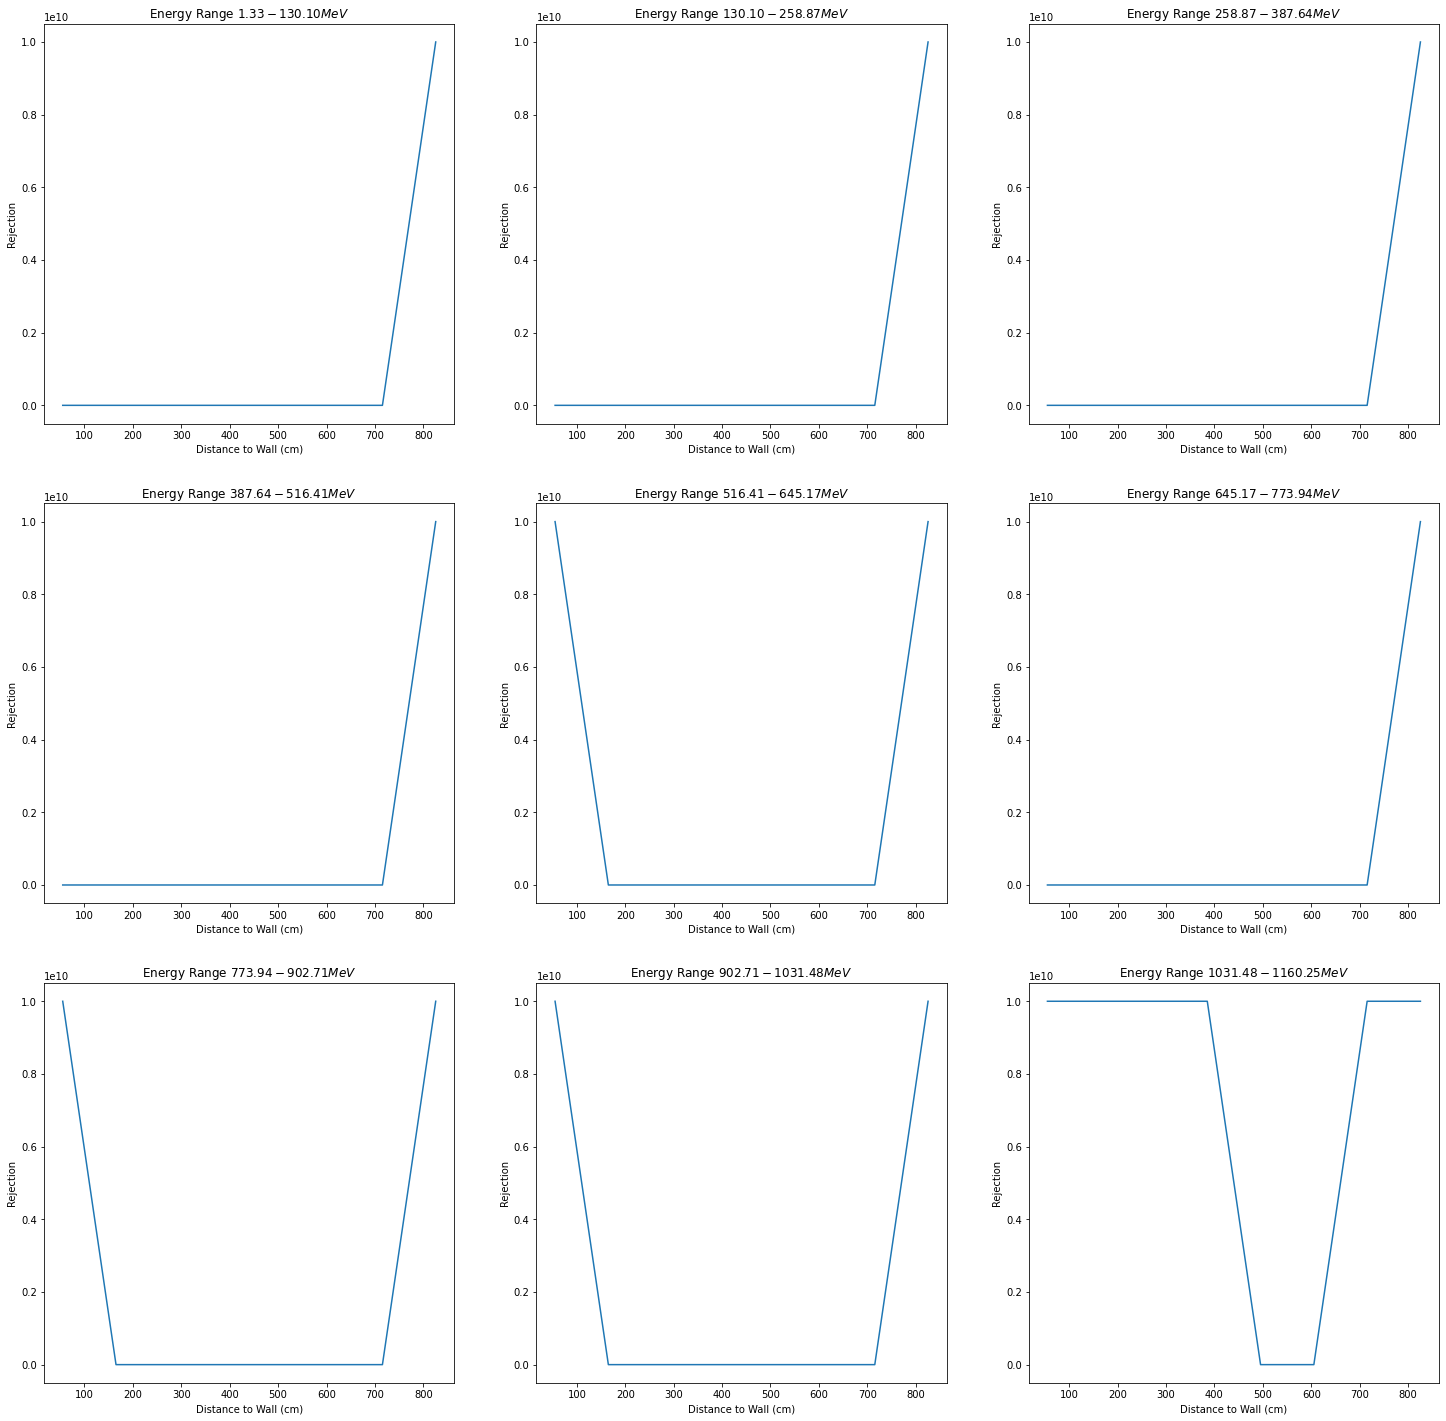

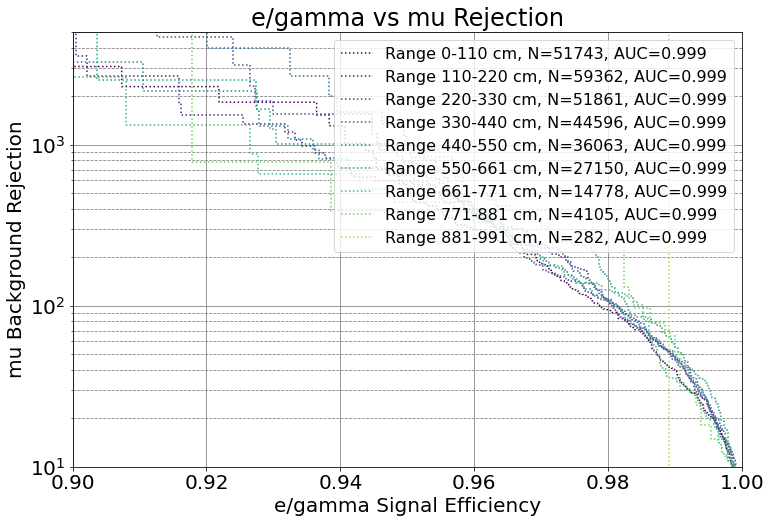

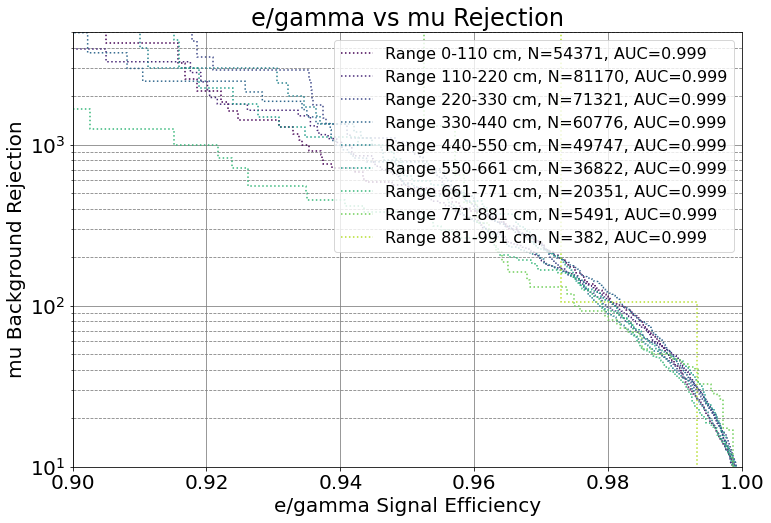

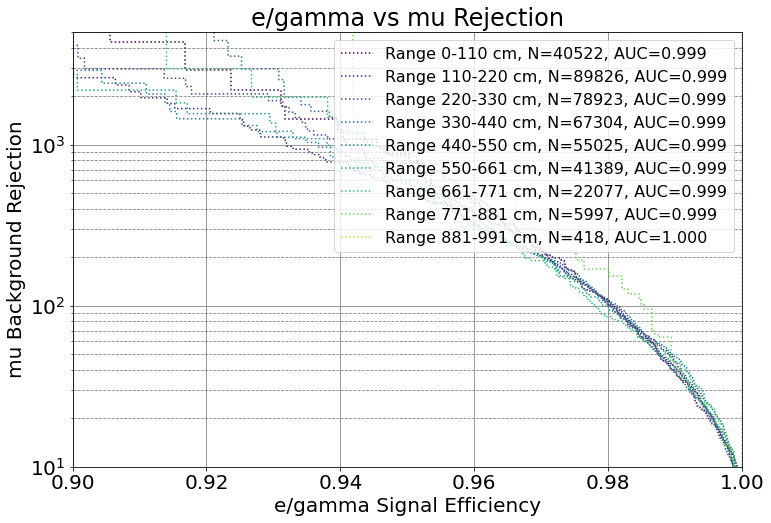

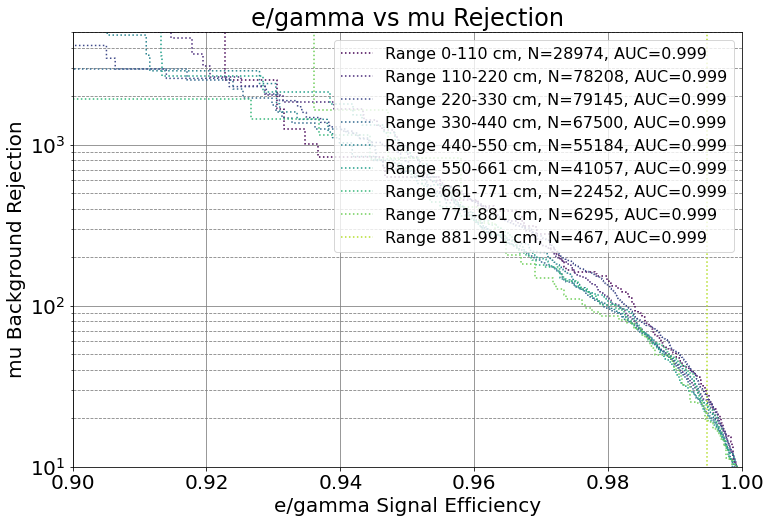

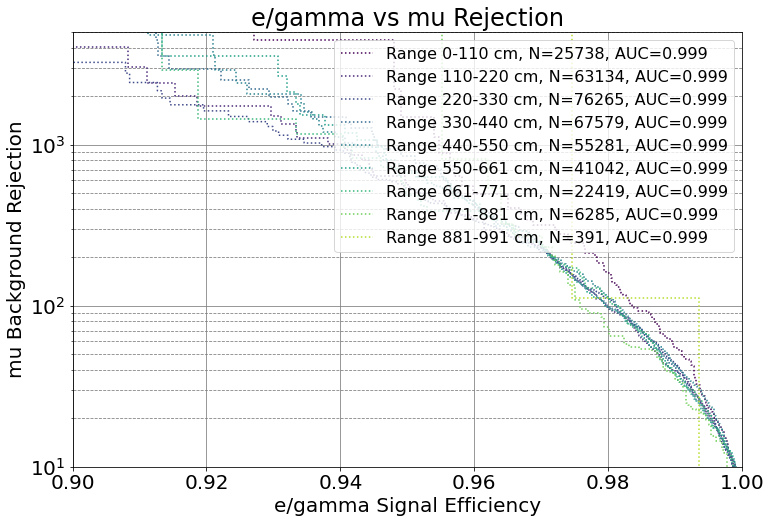

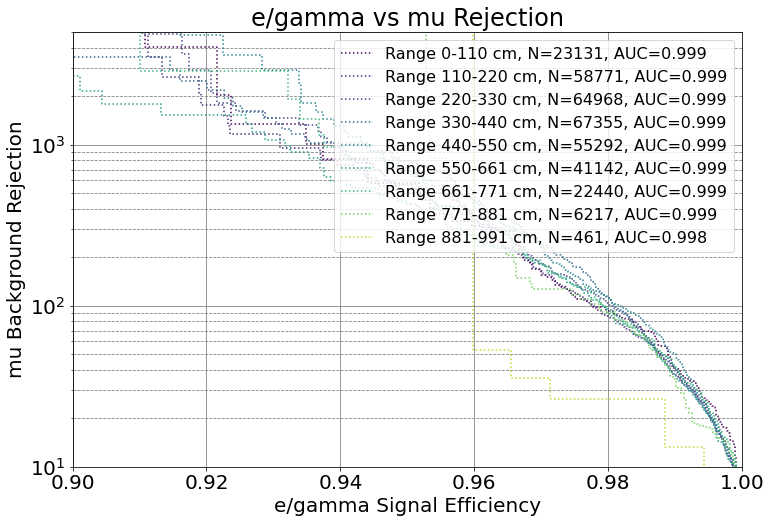

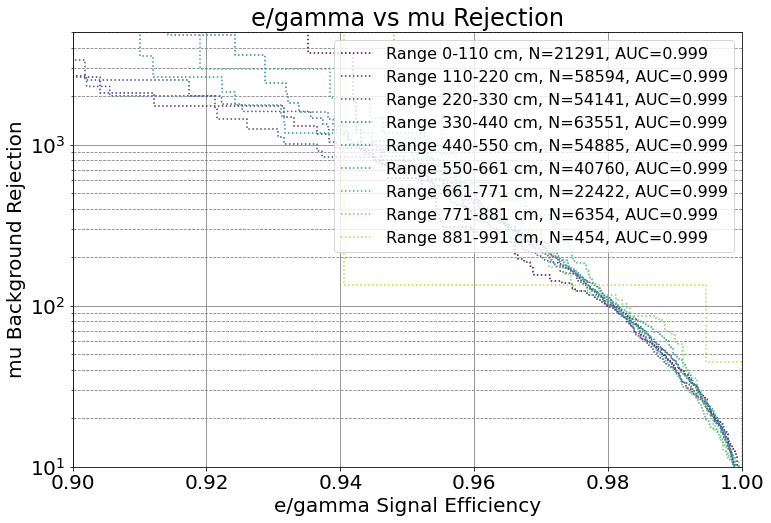

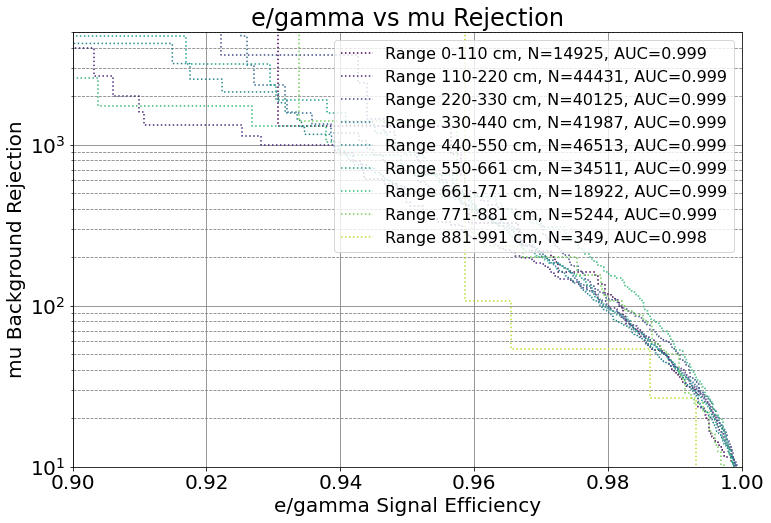

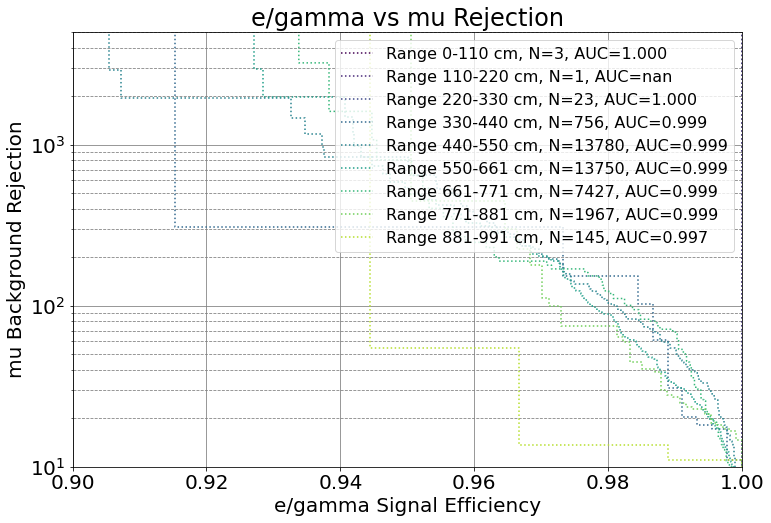

In [53]:
plot_muon_efficiencies(subset_energies      = test_energies, 
                       subset_d_to_wall     = test_d_to_wall, 
                       subset_softmax       = test_softmaxes, 
                       subset_labels        = test_labels, 
                       sample_efficency_val = 0.92)

[<AxesSubplot:>]
[<AxesSubplot:title={'center':'e/gamma vs mu Rejection'}, xlabel='e/gamma Signal Efficiency', ylabel='mu Background Rejection'>]
[<AxesSubplot:title={'center':'e/gamma vs mu Rejection'}, xlabel='e/gamma Signal Efficiency', ylabel='mu Background Rejection'>]
[<AxesSubplot:title={'center':'e/gamma vs mu Rejection'}, xlabel='e/gamma Signal Efficiency', ylabel='mu Background Rejection'>]
[<AxesSubplot:title={'center':'e/gamma vs mu Rejection'}, xlabel='e/gamma Signal Efficiency', ylabel='mu Background Rejection'>]
[<AxesSubplot:title={'center':'e/gamma vs mu Rejection'}, xlabel='e/gamma Signal Efficiency', ylabel='mu Background Rejection'>]
[<AxesSubplot:title={'center':'e/gamma vs mu Rejection'}, xlabel='e/gamma Signal Efficiency', ylabel='mu Background Rejection'>]
[<AxesSubplot:title={'center':'e/gamma vs mu Rejection'}, xlabel='e/gamma Signal Efficiency', ylabel='mu Background Rejection'>]
[<AxesSubplot:title={'center':'e/gamma vs mu Rejection'}, xlabel='e/gamma Signal

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:805: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


IndexError: cannot do a non-empty take from an empty axes.

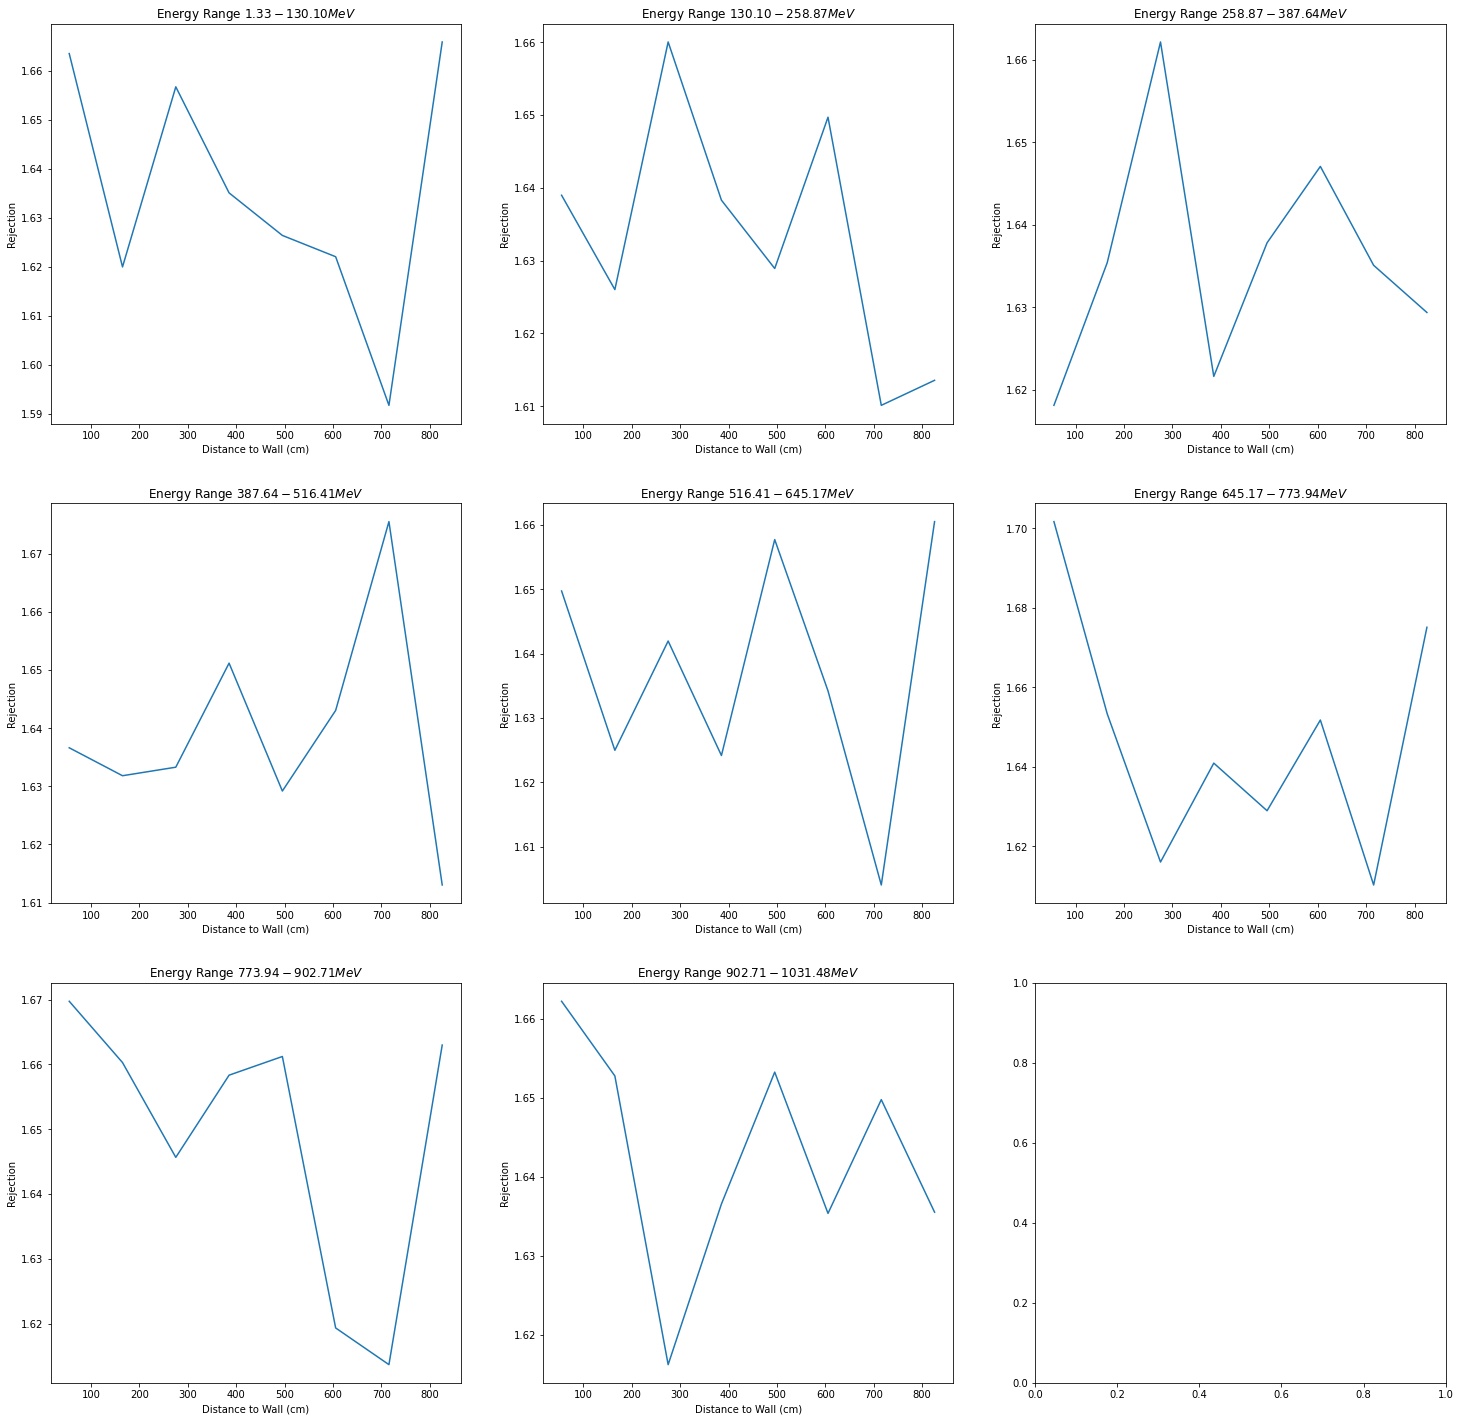

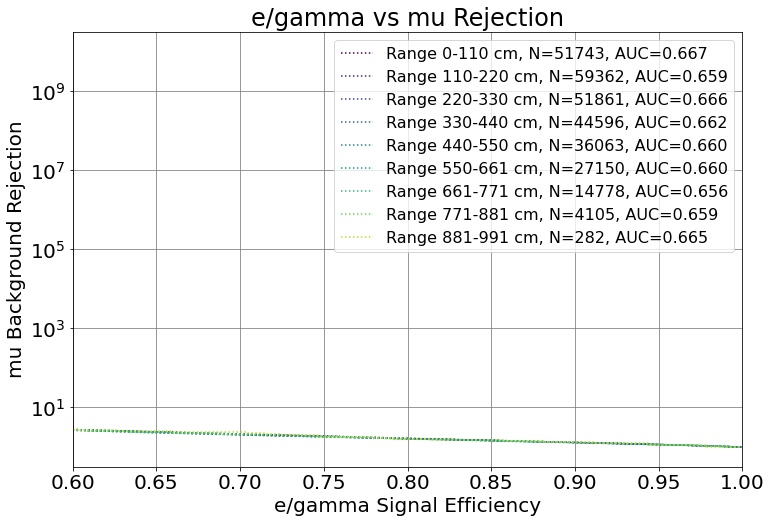

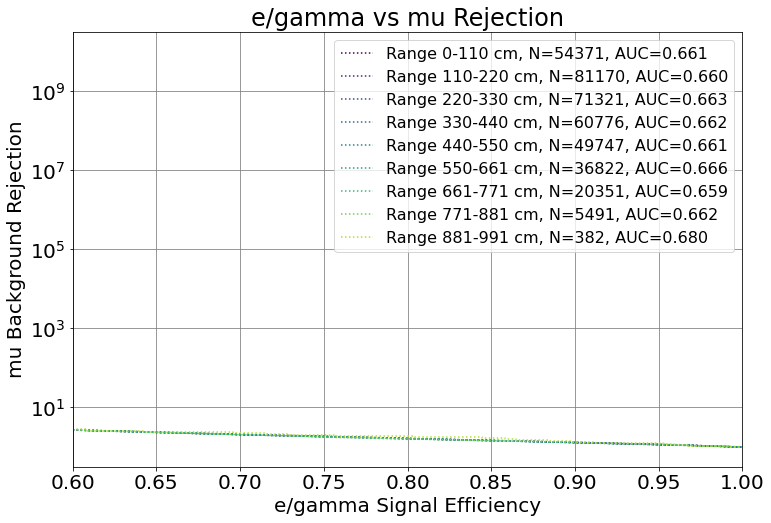

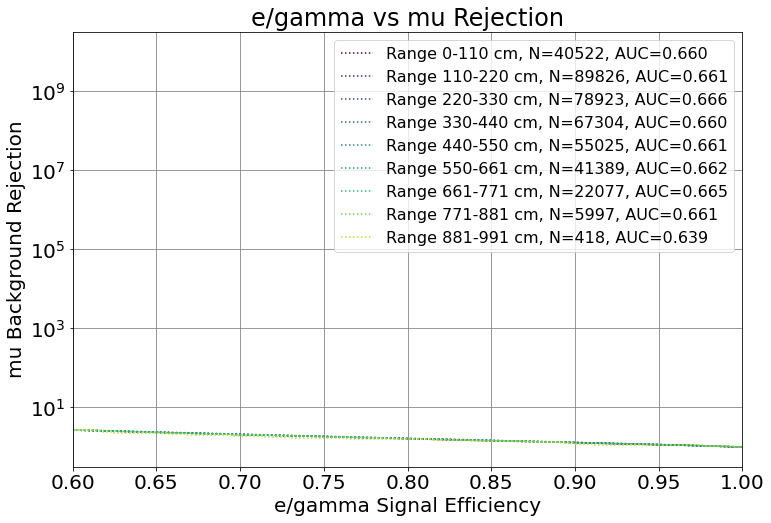

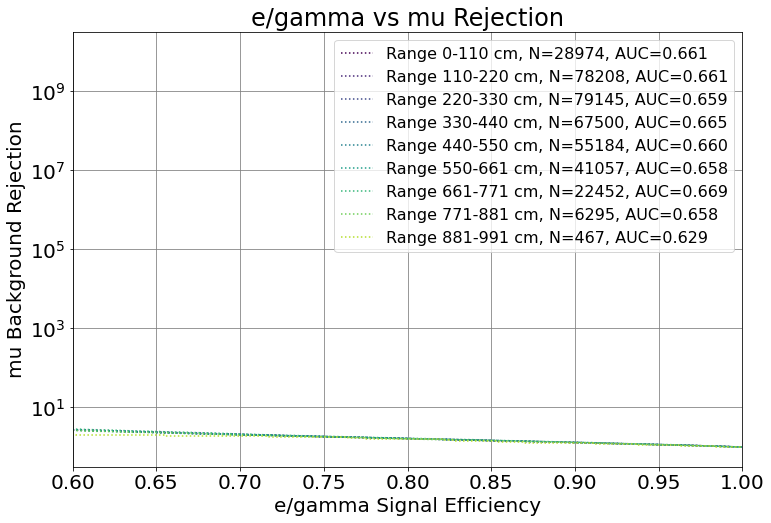

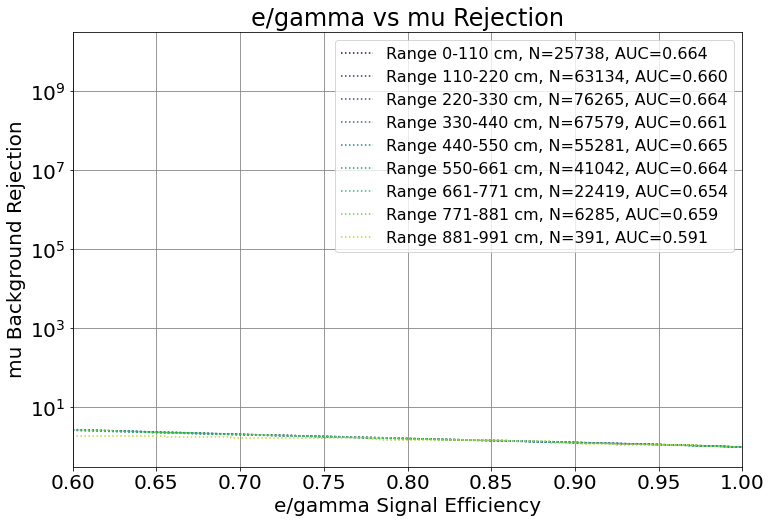

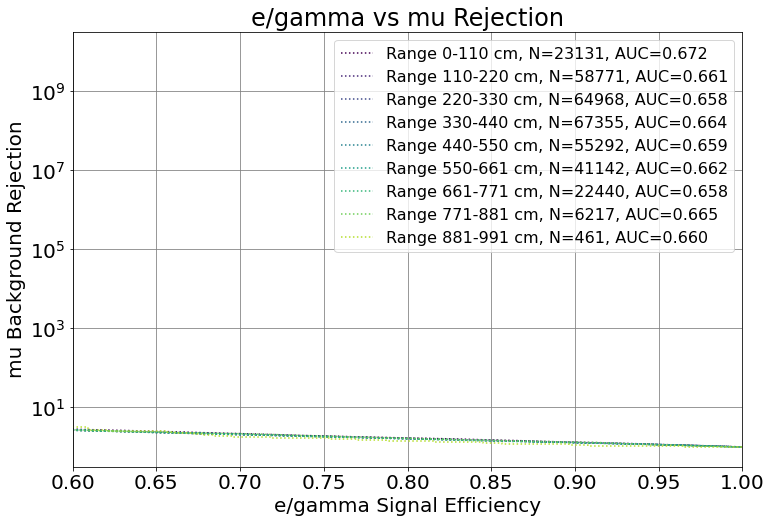

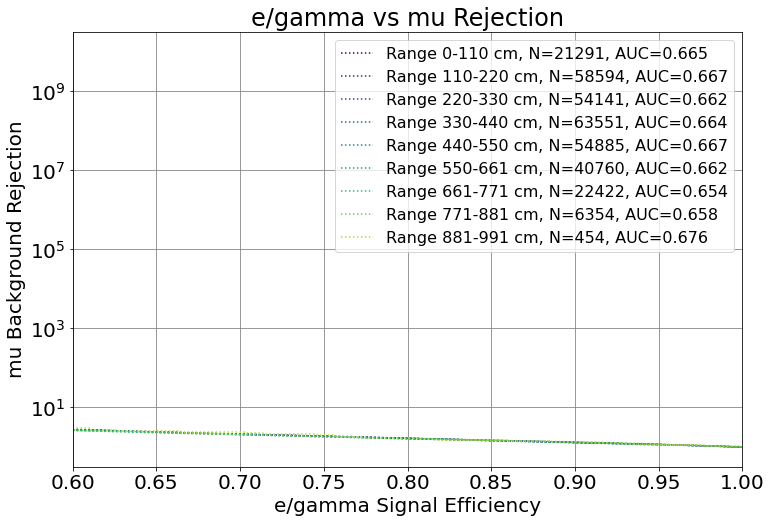

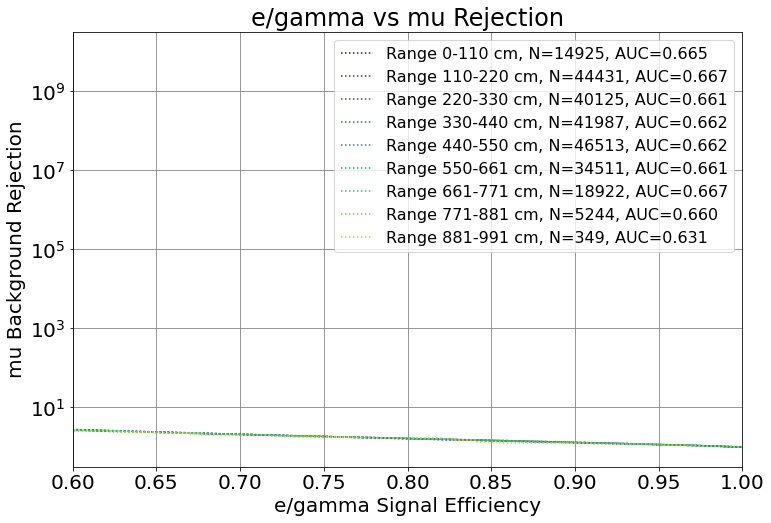

In [54]:
plot_efficiencies(subset_energies      = test_energies, 
                  subset_d_to_wall     = test_d_to_wall, 
                  subset_softmax       = test_softmaxes, 
                  subset_labels        = test_labels, 
                  sample_efficency_val = 0.8)